In [4]:
import tensorflow as tf
import tensorflow_io as tfio
from models.vqvae import *
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from loader import *

from IPython.display import Audio 
import librosa
import librosa.display

hparams = HParams(  
    # spectrogramming
    win_length = 2048,
    n_fft = 2048,
    hop_length= 256,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 256,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 10000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-09-30 01:13:26.971884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 01:13:26.997340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 01:13:26.997984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
from loader import get_training_set
from models.cvae import CVAE
dataset_len = 1276

train_dataset, test_dataset = get_training_set()
batch_size = 32


2021-09-30 01:13:29.502475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 01:13:29.503206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 01:13:29.504075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 01:13:29.504733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

loading spectrogram
not shape
loading spectrogram
not shape


In [6]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 64
num_examples_to_generate = 16

# model = CVAE(latent_dim)
vqvae_trainer = VQVAETrainer(latent_dim=16, num_embeddings=128)
vqvae_trainer.load_weights("/home/jerms/daniil/new_vae/saved_models/vqvae_run_1")
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

In [7]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(tf.math.log(predictions[i, :, :, 0]))
        plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


In [84]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=optimizer, metrics=["mae"])

In [57]:
# model.fit(test_good_sample, batch_size=16)

In [8]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_good_sample = test_batch[0:num_examples_to_generate, :, :, :]


2021-09-30 01:16:10.076693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [28]:
model.load_weights("./saved_models/second_real/")

2021-09-29 22:39:41.814074: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open ./saved_models/second_real/: Failed precondition: saved_models/second_real; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [9]:
def get_predictions(model, epoch, test_samples):
    mean, logvar = model.encode(test_samples)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

preds = get_predictions(model, 10, test_good_sample)

AttributeError: 'VQVAETrainer' object has no attribute 'encode'

In [58]:
audio_index = 1 # anywhere from 0 - 15

In [59]:
original_mel = test_good_sample[audio_index].numpy().reshape((176, 256))
original_audio = inv_mel_spec(original_mel, hparams)

In [63]:
predicted_mel = preds[audio_index].numpy().reshape(176, 256)
predicted_audio = inv_mel_spec(predicted_mel, hparams)

In [61]:
Audio(original_audio, rate=22050)

In [64]:
Audio(predicted_audio, rate=22050)

# Predicted

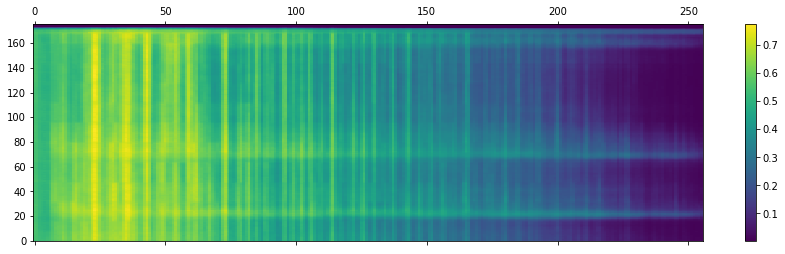

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(first_actual, aspect='auto', origin='lower')
fig.colorbar(cax)

# Original

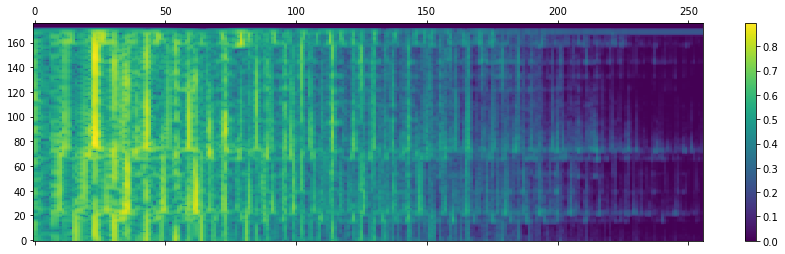

In [37]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(test_good_sample[5].numpy().reshape((176, 256)), aspect='auto', origin='lower')
fig.colorbar(cax)